## Setup

In [1]:
import os
import glob
import sys
import shutil
import pickle
import random as rnd
from tqdm import tqdm

import numpy as np
from numpy import random as np_rnd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import librosa

import torch
from torch import nn
from torch.nn import functional as F

from matplotlib import rc, rcParams
import matplotlib.font_manager as fm
rc('font', family=fm.FontProperties(fname='./font/NanumSquareR.ttf').get_name())
rcParams['axes.unicode_minus'] = False

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="w"):
    if op == "w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op == "r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def week_of_month(dt):
    """ 
        Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    return int(np.ceil(adjusted_dom/7.0))

def get_season(dt):
    dt = int(dt)
    if dt in [3, 4, 5]:
        return "봄"
    elif dt in [6, 7, 8]:
        return "여름"
    elif dt in [9, 10, 11]:
        return "가을"
    else:
        return "겨울"

In [3]:
class CFG:
    debug = True
    data_path = ".\\data\\"
    
    n_mfcc = 32
    n_chroma = 16

## Loading Data

In [4]:
df = pd.read_csv("./data/pig_month_feed_prep.csv")

In [5]:
df

,지역,규모,농장,품종,산차,급이횟수,급이설정량,섭취량,급이일자,분만일로부터의 기간,분만일,총산,실산,분만시BCS,이유일,이유두수,이유총체,이유평체,재귀발정일
0,NaN,1000두 이상,PF_0020082,F1,7,3.0,7.5,7.5,2022-01-18,13,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
1,NaN,1000두 이상,PF_0020082,F1,7,3.0,8.0,8.0,2022-01-19,14,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
2,NaN,1000두 이상,PF_0020082,F1,7,3.0,8.0,8.0,2022-01-20,15,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
3,NaN,1000두 이상,PF_0020082,F1,7,3.0,8.0,8.0,2022-01-21,16,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
4,NaN,1000두 이상,PF_0020082,F1,7,3.0,8.0,8.0,2022-01-22,17,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117535,NaN,1000두 이상,PF_0020082,F1,6,2.0,3.0,3.0,2021-10-25,1,2021-10-24,11,10,17.0,2021-11-18,10,67.0,6.7,4.0
117536,NaN,1000두 이상,PF_0020082,F1,6,2.0,4.0,4.0,2021-10-26,2,2021-10-24,11,10,17.0,2021-11-18,10,67.0,6.7,4.0
117537,NaN,1000두 이상,PF_0020082,F1,6,2.0,5.0,5.1,2021-10-27,3,2021-10-24,11,10,17.0,2021-11-18,10,67.0,6.7,4.0
117538,NaN,1000두 이상,PF_0020082,F1,6,2.0,6.0,6.0,2021-10-28,4,2021-10-24,11,10,17.0,2021-11-18,10,67.0,6.7,4.0


In [6]:
df.isna().sum()

지역            117540
규모                 0
농장                 0
품종                 0
산차                 0
급이횟수               0
급이설정량              0
섭취량                0
급이일자               0
분만일로부터의 기간         0
분만일                0
총산                 0
실산                 0
분만시BCS          1730
이유일                0
이유두수               0
이유총체               0
이유평체            2757
재귀발정일          11640
dtype: int64

In [7]:
df.nunique()

지역              0
규모              1
농장              1
품종              1
산차             13
급이횟수            2
급이설정량          25
섭취량           158
급이일자          160
분만일로부터의 기간     51
분만일           182
총산             25
실산             23
분만시BCS         15
이유일            79
이유두수           23
이유총체          267
이유평체           17
재귀발정일          48
dtype: int64

In [8]:
# drop columns, rows
df = df.drop(["지역", "규모", "농장", "품종"], axis=1).dropna()
df.shape

(104121, 15)

In [9]:
df["급이일자"] = pd.to_datetime(df["급이일자"])
df["분만일"] = pd.to_datetime(df["분만일"])
df["이유일"] = pd.to_datetime(df["이유일"])

In [10]:
df.head()

,산차,급이횟수,급이설정량,섭취량,급이일자,분만일로부터의 기간,분만일,총산,실산,분만시BCS,이유일,이유두수,이유총체,이유평체,재귀발정일
0,7,3.0,7.5,7.5,2022-01-18,13,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
1,7,3.0,8.0,8.0,2022-01-19,14,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
2,7,3.0,8.0,8.0,2022-01-20,15,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
3,7,3.0,8.0,8.0,2022-01-21,16,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0
4,7,3.0,8.0,8.0,2022-01-22,17,2022-01-05,11,10,19.0,2022-01-28,8,52.8,6.6,4.0


## Add climate feature

In [11]:
# Temperature
seoul_temp = pd.read_csv("./data/seoul_temperature_high.csv", encoding="cp949").dropna()
seoul_temp = seoul_temp[["일시", "최고기온(℃)"]]
seoul_temp.columns = ["timestamp", "temp"]
seoul_temp["timestamp"] = pd.to_datetime(seoul_temp["timestamp"])
seoul_temp = seoul_temp.set_index("timestamp")["temp"]

In [12]:
seoul_temp

timestamp
2015-01-01    -4.3
2015-01-02    -1.9
2015-01-03     3.1
2015-01-04     8.5
2015-01-05     7.9
              ... 
2023-03-10    22.2
2023-03-11    22.8
2023-03-12    12.6
2023-03-13     7.6
2023-03-14    15.4
Name: temp, Length: 2993, dtype: float64

In [13]:
# Humidity
busan_hum = pd.read_csv("./data/busan_humidity_mean.csv", encoding="cp949").dropna()
busan_hum = busan_hum[["일시", "평균습도(%rh)"]]
busan_hum.columns = ["timestamp", "hum"]
busan_hum["timestamp"] = pd.to_datetime(busan_hum["timestamp"])
busan_hum = busan_hum.set_index("timestamp")["hum"]

In [14]:
busan_hum

timestamp
2015-01-01    35.4
2015-01-02    41.3
2015-01-03    32.0
2015-01-04    53.8
2015-01-05    67.4
              ... 
2023-03-10    78.0
2023-03-11    85.1
2023-03-12    79.8
2023-03-13    40.1
2023-03-14    56.4
Name: hum, Length: 2995, dtype: float64

## EDA on 생존두수비율 (Percentage)

In [15]:
df_eda = df.copy()

In [16]:
(df_eda == 0).sum()

산차               0
급이횟수             0
급이설정량            2
섭취량           8458
급이일자             0
분만일로부터의 기간    3583
분만일              0
총산               0
실산               0
분만시BCS           0
이유일              0
이유두수             0
이유총체             0
이유평체             0
재귀발정일            0
dtype: int64

In [17]:
df_eda.loc[df_eda["급이설정량"] == 0, "급이설정량"] = np.nan
df_eda.loc[df_eda["섭취량"] == 0, "섭취량"] = np.nan

In [18]:
df_eda = df_eda.groupby(["분만일", "이유일", "총산", "분만시BCS"]).mean()

In [19]:
df_eda["temp"] = df_eda.index.get_level_values(0).map(seoul_temp).values
df_eda["hum"] = df_eda.index.get_level_values(0).map(busan_hum).values

In [20]:
df_eda["month"] = df_eda.index.get_level_values(0).month.values
df_eda["season"] = df_eda["month"].apply(get_season)

In [21]:
df_eda = df_eda.reset_index(["총산", "분만시BCS"])

In [22]:
# add target metric
df_eda = df_eda[df_eda["총산"] > 0]
df_eda = df_eda[df_eda["이유두수"] >= 0]
df_eda = df_eda[df_eda["이유두수"] <= df_eda["총산"]]
df_eda["생존두수비율"] = df_eda["이유두수"] / df_eda["총산"]
print(df_eda["생존두수비율"].describe())

count    3238.000000
mean        0.837008
std         0.136278
min         0.166667
25%         0.750000
50%         0.854567
75%         0.937500
max         1.000000
Name: 생존두수비율, dtype: float64


In [23]:
df_eda.iloc[:20]

총산  분만시BCS        산차  급이횟수     급이설정량       섭취량  \
분만일        이유일                                                          
2021-10-07 2021-11-04  15    18.0  4.000000   3.0  6.085714  5.320000   
2021-10-08 2021-11-04  10    17.0  3.000000   3.0  3.800000  3.800000   
2021-10-12 2021-11-04   9    17.0  3.000000   3.0  6.800000  6.487500   
           2021-11-04  14    15.0  3.000000   3.0  7.057692  6.544000   
           2021-11-04  16    18.0  7.000000   3.0  6.980769  6.632000   
           2021-11-04  20    19.0  3.000000   3.0  6.892593  6.388000   
           2021-11-05  16    18.0  9.000000   3.0  6.711538  6.508000   
2021-10-13 2021-11-04  13    17.0  2.000000   3.0  6.646296  5.538000   
           2021-11-04  14    15.0  2.981132   3.0  6.656604  6.184000   
           2021-11-04  14    18.0  2.000000   3.0  6.603704  6.004000   
           2021-11-04  16    15.0  2.000000   3.0  6.429630  6.228000   
           2021-11-04  17    15.0  5.000000   3.0  6.711538  5.628000   
           2021-11-04  18    18.0  2.000000   3.0  6.603704  5.296000   
           2021-11-05   8    17.0  1.000000   3.0  6.696774  4.868000   
           2021-11-05  10    17.0  1.000000   3.0  6.711538  5.044000   
           2021-11-05  15    17.0  5.000000   3.0  7.123333  6.834783   
           2021-11-05  18    16.0  8.000000   3.0  6.711538  6.512000   
2021-10-14 2021-11-04   7    18.0  3.000000   3.0  6.530769  5.658333   
           2021-11-04  11    16.0  4.000000   3.0  6.530769  6.084000   
           2021-11-04  11    17.0  6.000000   3.0  6.429630  5.944000   

                       분만일로부터의 기간         실산       이유두수        이유총체  이유평체  \
분만일        이유일                                                              
2021-10-07 2021-11-04   20.000000  11.000000   9.000000   63.000000   7.0   
2021-10-08 2021-11-04   27.500000  10.000000  10.000000   70.000000   7.0   
2021-10-12 2021-11-04   10.615385   9.000000   9.000000   63.000000   7.0   
           2021-11-04   11.500000  13.000000  10.000000   70.000000   7.0   
           2021-11-04   11.500000  12.000000  12.000000   84.000000   7.0   
           2021-11-04   11.000000  18.000000  16.000000  112.000000   7.0   
           2021-11-05   11.500000  10.000000  10.000000   66.000000   6.6   
2021-10-13 2021-11-04   10.000000  12.000000   9.000000   63.000000   7.0   
           2021-11-04   10.245283  12.528302  12.037736   84.264151   7.0   
           2021-11-04   10.000000  14.000000  12.000000   84.000000   7.0   
           2021-11-04   10.000000  15.000000  15.000000  105.000000   7.0   
           2021-11-04   10.500000  13.000000  13.000000   91.000000   7.0   
           2021-11-04   10.000000  16.000000  16.000000  112.000000   7.0   
           2021-11-05   14.000000   7.000000   7.000000   46.200000   6.6   
           2021-11-05   10.500000   8.000000   6.000000   39.600000   6.6   
           2021-11-05   13.500000  13.000000  13.000000   85.800000   6.6   
           2021-11-05   10.500000  14.000000  12.000000   79.200000   6.6   
2021-10-14 2021-11-04    9.500000   7.000000   5.000000   35.000000   7.0   
           2021-11-04    9.500000  10.000000   8.000000   56.000000   7.0   
           2021-11-04    9.000000   9.000000   7.000000   49.000000   7.0   

                       재귀발정일  temp   hum  month season    생존두수비율  
분만일        이유일                                                    
2021-10-07 2021-11-04    5.0  21.9  76.4     10     가을  0.600000  
2021-10-08 2021-11-04    5.0  20.0  77.9     10     가을  1.000000  
2021-10-12 2021-11-04    4.0  21.3  80.6     10     가을  1.000000  
           2021-11-04    4.0  21.3  80.6     10     가을  0.714286  
           2021-11-04    4.0  21.3  80.6     10     가을  0.750000  
           2021-11-04    4.0  21.3  80.6     10     가을  0.800000  
           2021-11-05    4.0  21.3  80.6     10     가을  0.625000  
2021-10-13 2021-11-04    8.5  25.2  75.0     10     가을  0.692308  
           2021-11-04    4.0  25.2  75.0     10    

In [24]:
df_eda.isna().sum().sum()

0

### Correlation heatmap on numerical feature

In [25]:
feature_info = {
    "cat_vars": ["month", "season"],
    "num_vars": [],
}
feature_info["num_vars"] = diff(df_eda.columns, feature_info["cat_vars"])
feature_info

{'cat_vars': ['month', 'season'],
 'num_vars': ['총산',
  '분만시BCS',
  '산차',
  '급이횟수',
  '급이설정량',
  '섭취량',
  '분만일로부터의 기간',
  '실산',
  '이유두수',
  '이유총체',
  '이유평체',
  '재귀발정일',
  'temp',
  'hum',
  '생존두수비율']}

In [26]:
df_corr = df_eda.drop(["month", "season"], axis=1).corr()

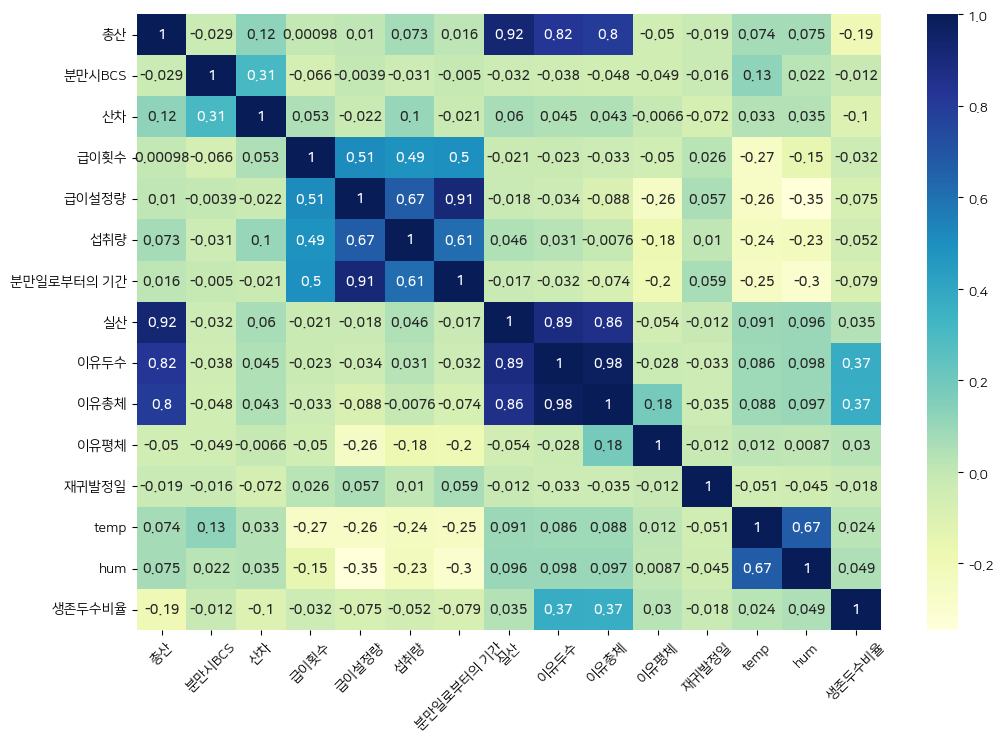

In [27]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, cmap="YlGnBu", annot=True, annot_kws={"fontweight": "bold"})
plt.xticks(rotation=45)
plt.show()

In [28]:
lm_x = pd.DataFrame(StandardScaler().fit_transform(df_eda[feature_info["num_vars"]].drop("생존두수비율", axis=1)), columns=df_eda[feature_info["num_vars"]].drop("생존두수비율", axis=1).columns)
lm_y = df_eda["생존두수비율"].copy().values
model = sm.OLS(lm_y, lm_x)
result = model.fit()
lm_x.head()

,총산,분만시BCS,산차,급이횟수,급이설정량,섭취량,분만일로부터의 기간,실산,이유두수,이유총체,이유평체,재귀발정일,temp,hum
0,0.517117,0.820181,0.154008,1.272206,-0.084440,-0.375842,3.082522,-0.316601,-0.659884,-0.625304,0.120137,-0.061334,1.843320,1.627168
1,-0.954259,0.191899,-0.315848,1.272206,-3.021784,-2.145130,4.969351,-0.636035,-0.329212,-0.298398,0.120137,-0.061334,1.572404,1.728488
2,-1.248534,0.191899,-0.315848,1.272206,0.833480,0.983135,0.721567,-0.955469,-0.659884,-0.625304,0.120137,-0.276018,1.757767,1.910863
3,0.222842,-1.064663,-0.315848,1.272206,1.164638,1.048901,0.944116,0.322267,-0.329212,-0.298398,0.120137,-0.276018,1.757767,1.910863
4,0.811393,0.820181,1.563576,1.272206,1.065785,1.151334,0.944116,0.002833,0.332134,0.355413,0.120137,-0.276018,1.757767,1.910863


In [29]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.019
Method:                 Least Squares   F-statistic:                              5.488
Date:                Fri, 17 Mar 2023   Prob (F-statistic):                    1.51e-10
Time:                        15:10:17   Log-Likelihood:                         -4022.6
No. Observations:                3238   AIC:                                      8073.
Df Residuals:                    3224   BIC:                                      8158.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총산            -0.2134      0.039     -5.434      0.000      -0.290      -0.136
분만시BCS         0.0006      0.016      0.040      0.968      -0.030       0.032
산차             0.0013      0.016      0.082      0.935      -0.030       0.033
급이횟수           0.0010      0.018      0.055      0.956      -0.035       0.037
급이설정량         -0.0049      0.041     -0.119      0.905      -0.085       0.076
섭취량            0.0030      0.021      0.142      0.887      -0.038       0.044
분만일로부터의 기간     0.0017      0.037      0.047      0.962      -0.071       0.074
실산             0.0050      0.048      0.104      0.917      -0.089       0.099
이유두수           0.2485      0.246      1.009      0.313      -0.234       0.731
이유총체          -0.0275      0.249     -0.110      0.912      -0.516       0.461
이유평체           0.0054      0.055      0.099      0.921      -0.102       0.113
재귀발정일          0.0011      0.015      0.071      0.944      -0.028       0.030
temp          -0.0008      0.021     -0.040      0.968      -0.042       0.040
hum            0.0007      0.021      0.034      0.973      -0.041       0.042
==============================================================================
Omnibus:                     1916.792   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68421.928
Skew:                          -2.222   Prob(JB):                         0.00
Kurtosis:                      25.077   Cond. No.                         46.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Note: Summarization

* There isn't any variable which shows high correlation with others

### Box plot on categorical feature

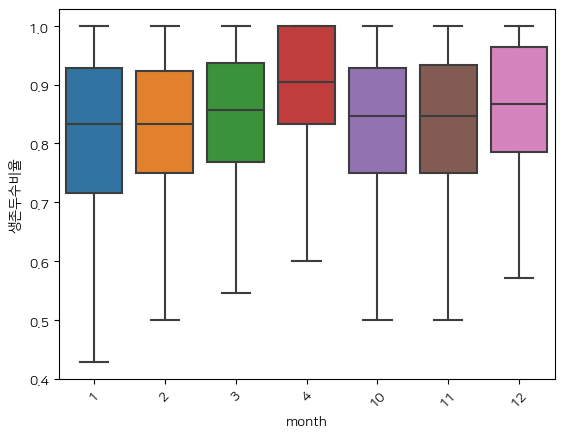

ANOVA : Groups are different -> 0.0


month,1,2,3,4,10,11,12
생존두수비율,0.814162,0.825059,0.84082,0.883968,0.834291,0.833883,0.857759


In [38]:
for i in ["month", "season"]:
    _, pvalue = f_oneway(*[df_eda.loc[df_eda[i] == j, "생존두수비율"].values for j in df_eda[i].unique()])
    if pvalue < 0.05:
        sns.boxplot(x=df_eda[i], y=df_eda["생존두수비율"], showfliers=False)
        plt.xticks(rotation=45)
        plt.show()
        print(f"ANOVA : Groups are different -> {np.round(pvalue, 5)}")
        if "season" in i:
            display(df_eda.groupby(i)["생존두수비율"].mean().to_frame().T[["봄", "여름", "가을", "겨울"]])
        else:
            display(df_eda.groupby(i)["생존두수비율"].mean().to_frame().T)

### Note: Summarization

* 분만일이 4월일 떄 생존두수비율이 비교적 높게 나타난다.

### Group analysis

In [31]:
stats = df_eda["생존두수비율"].describe()
stats

count    3238.000000
mean        0.837008
std         0.136278
min         0.166667
25%         0.750000
50%         0.854567
75%         0.937500
max         1.000000
Name: 생존두수비율, dtype: float64

In [32]:
df_eda["group"] = "생존두수비율_middle"
df_eda.loc[df_eda["생존두수비율"] >= stats["75%"], "group"] = "생존두수비율_high"
df_eda.loc[df_eda["생존두수비율"] <= stats["25%"], "group"] = "생존두수비율_low"

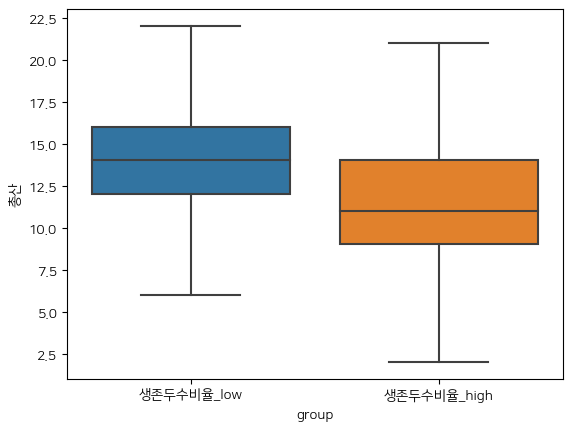

ANOVA : Groups are different -> 0.0


group,생존두수비율_low,생존두수비율_high
총산,13.786241,11.469807


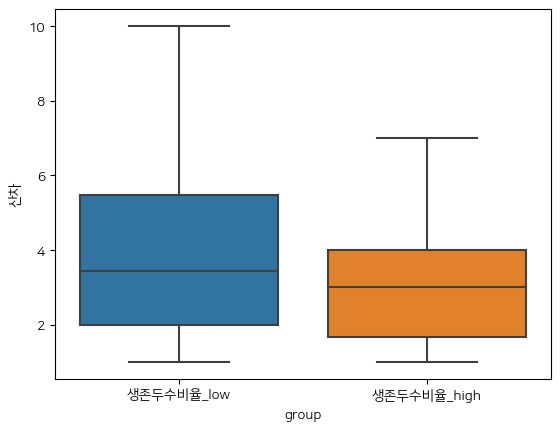

ANOVA : Groups are different -> 0.0


group,생존두수비율_low,생존두수비율_high
산차,3.893672,3.196812


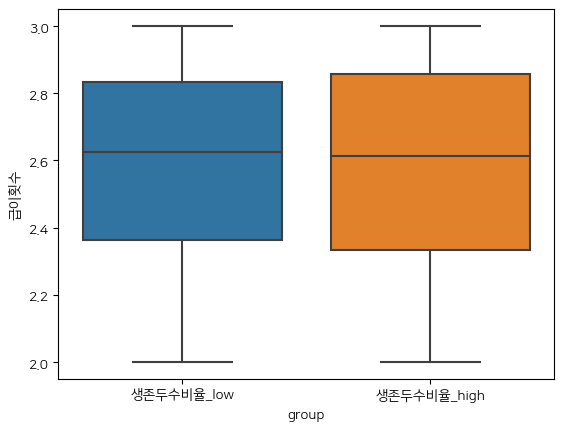

ANOVA : Groups are different -> 0.04197


group,생존두수비율_low,생존두수비율_high
급이횟수,2.600784,2.568295


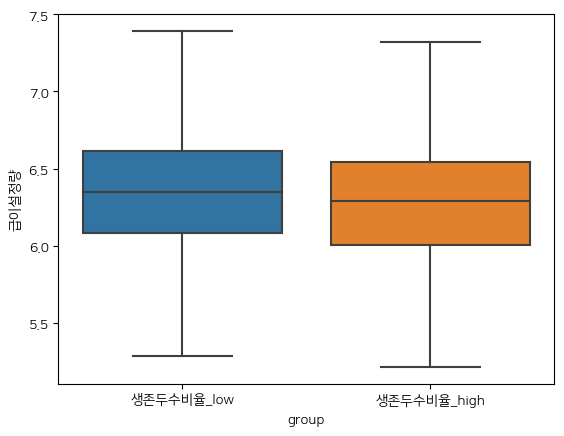

ANOVA : Groups are different -> 0.00013


group,생존두수비율_low,생존두수비율_high
급이설정량,6.225063,6.076922


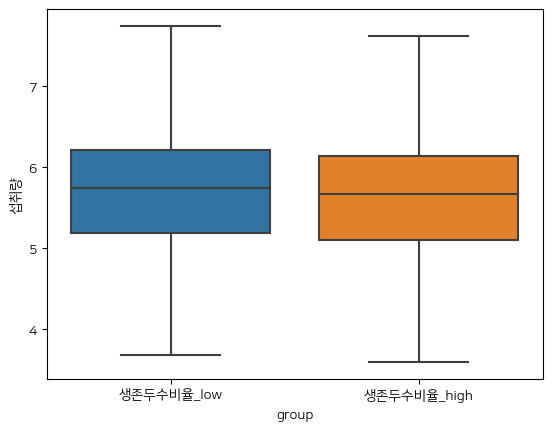

ANOVA : Groups are different -> 0.00148


group,생존두수비율_low,생존두수비율_high
섭취량,5.674796,5.539352


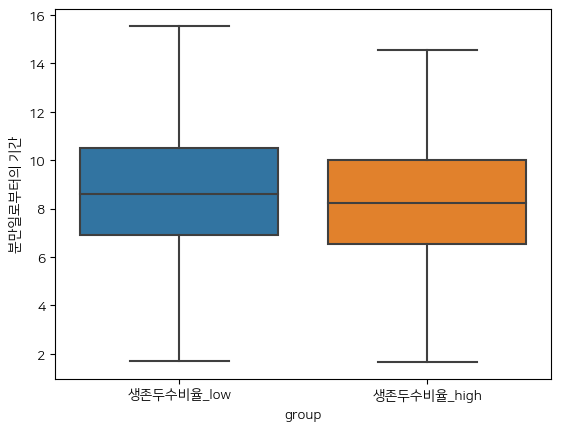

ANOVA : Groups are different -> 8e-05


group,생존두수비율_low,생존두수비율_high
분만일로부터의 기간,8.174493,7.408104


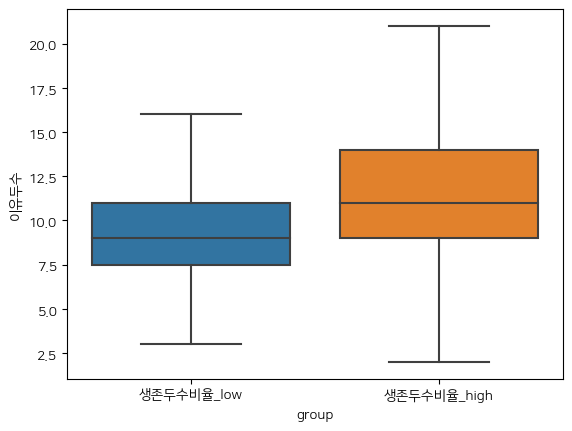

ANOVA : Groups are different -> 0.0


group,생존두수비율_low,생존두수비율_high
이유두수,9.097456,11.329196


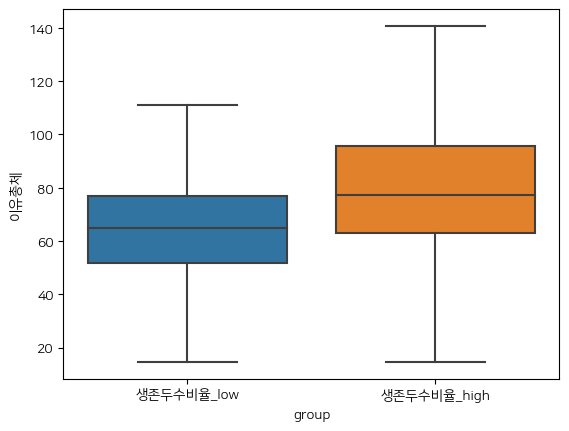

ANOVA : Groups are different -> 0.0


group,생존두수비율_low,생존두수비율_high
이유총체,62.816664,78.816309


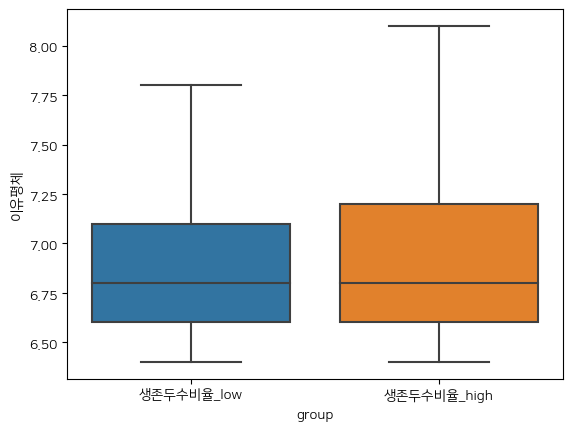

ANOVA : Groups are different -> 0.03355


group,생존두수비율_low,생존두수비율_high
이유평체,6.912776,6.955435


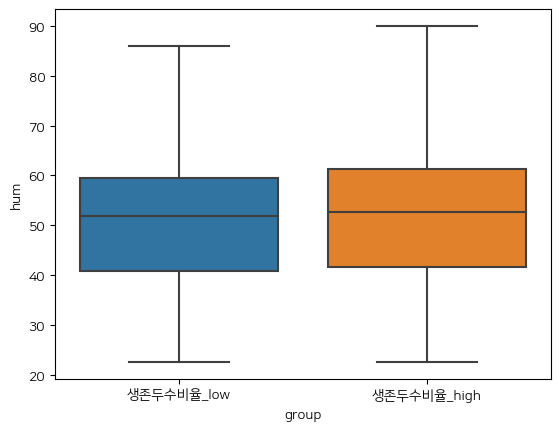

ANOVA : Groups are different -> 0.04044


group,생존두수비율_low,생존두수비율_high
hum,51.765356,53.273913


In [42]:
for i in df_eda.columns[:14]:
    _, pvalue = f_oneway(df_eda.loc[df_eda["group"] == "생존두수비율_high", i].values, df_eda.loc[df_eda["group"] == "생존두수비율_low", i].values)
    if pvalue < 0.05:
        sns.boxplot(x=df_eda.loc[df_eda["group"] != "생존두수비율_middle", "group"], y=df_eda.loc[df_eda["group"] != "생존두수비율_middle", i], showfliers=False)
        # plt.xticks(rotation=45)
        plt.show()
        print(f"ANOVA : Groups are different -> {np.round(pvalue, 5)}")
        if "season" in i:
            display(df_eda.groupby("group")[i].mean().to_frame().iloc[:2].T[["생존두수비율_low", "생존두수비율_high"]])
        else:
            display(df_eda.groupby("group")[i].mean().to_frame().iloc[:2].T[["생존두수비율_low", "생존두수비율_high"]])

In [34]:
df_eda.groupby("group")[df_eda.columns[:14]].mean().iloc[:2].T

group,생존두수비율_high,생존두수비율_low
총산,11.469807,13.786241
분만시BCS,16.705314,16.775184
산차,3.196812,3.893672
급이횟수,2.568295,2.600784
급이설정량,6.076922,6.225063
섭취량,5.539352,5.674796
분만일로부터의 기간,7.408104,8.174493
실산,11.327958,11.573327
이유두수,11.329196,9.097456
이유총체,78.816309,62.816664


총산 평균: 13.242742433600988


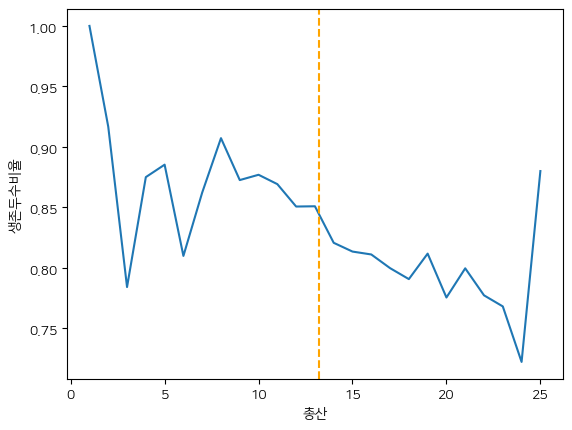

In [46]:
print("총산 평균:", df_eda["총산"].mean())
sns.lineplot(df_eda.groupby(["총산"])["생존두수비율"].mean().sort_index())
# only one line may be specified; full height
plt.axvline(x=df_eda["총산"].mean(), linestyle="--", color='orange')
plt.show()

<Axes: xlabel='총산', ylabel='Count'>

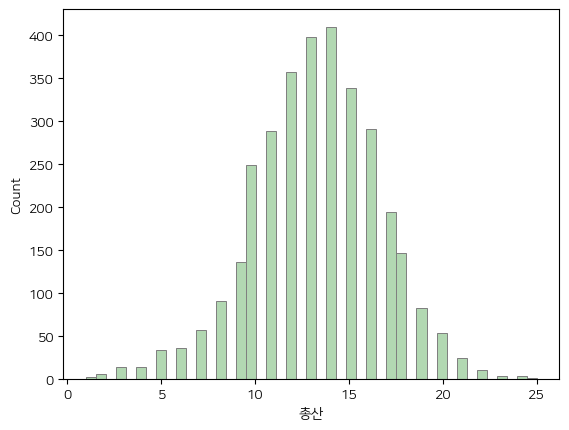

In [36]:
sns.histplot(df_eda["총산"], alpha=0.3, color="green", edgecolor="grey")

### Note: Summarization

* 생존두수비율이 높은 그룹은 먹이를 비교적 더 적게 먹는다.
* 생존두수비율이 높은 그룹은 분만일로부터 급이를 시작한 기간이 더 적다.
* 생존두수비율이 높은 그룹 분만일의 온도와 습도가 비교적 더 높다. (고온다습한 특징으로 봄~여름철로 보인다.)
* 생존두수비율이 높은 그룹은 총산 평균이 낮은 그룹보다 낮지만 이유두수가 총산과 거의 유사하다. 즉, 아기 돼지를 낳는 절대적 수는 낮지만 생존비율이 높다.